In [17]:
#imports
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import os

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [18]:
#reading the csv file
dir  = globals()['_dh'][0].parent
file_path = dir / 'data' / 'cleaned_data.pkl'
df = pd.read_pickle(file_path)
print(df.shape)
df.head(5)


(16680, 16)


,OrgID,EnrollDate,ChurnDate,OrgSize,Industry,IndustryGroup,Enrollment Plan,PromoType,Acquisition Channel,F28 Active Rate,Avg Lifetime Active,F28 Cc Flag,eLTV/CAC,Churned,Enrollment Duration,User_id
0,44,2021-02-01,NaT,0-1,Flooring,Other,Extra large,No Promo,Marketing - Paid,0.607,0.096,0,4.1,0,676.0,4420210201
1,70,2022-03-01,NaT,0-1,Plumbing,Plumbing,Starter,No Promo,NaN,0.071,0.340,0,1.2,0,283.0,7020220301
2,1494,2020-10-02,NaT,0-1,Carpet Cleaning,Carpet Cleaning,Small,No Promo,Product,1.000,0.379,1,3.4,0,798.0,149420201002
3,1604,2020-10-08,2020-12-08,11+,Restoration,Other,Large,2+ month,Sales,0.500,0.004,0,6.2,1,61.0,160420201008
4,1652,2020-02-03,2020-03-02,11+,Solar & Energy,Other,Large,One Month,Sales,0.000,0.001,0,4.7,1,28.0,165220200203


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16680 entries, 0 to 16679
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   OrgID                16680 non-null  int64         
 1   EnrollDate           16680 non-null  datetime64[ns]
 2   ChurnDate            6703 non-null   datetime64[ns]
 3   OrgSize              16671 non-null  category      
 4   Industry             16655 non-null  object        
 5   IndustryGroup        16680 non-null  object        
 6   Enrollment Plan      16677 non-null  category      
 7   PromoType            16680 non-null  category      
 8   Acquisition Channel  15947 non-null  object        
 9   F28 Active Rate      16680 non-null  float64       
 10  Avg Lifetime Active  16680 non-null  float64       
 11  F28 Cc Flag          16680 non-null  int64         
 12  eLTV/CAC             16549 non-null  float64       
 13  Churned              16680 non-

## 1 - Analysing from Industry
Findings: \
1 - This field Industry Group must be revisited as the groups are of low quality \
3 - There are underworked industries with a large ltv/cac ratio but with a small number of users that can be exploited \
4 - Heating, Plumbing and Eletrical are the ones that contribute the most for a positive financial impact \
5 - Handyman and General Contractor can be better exploited to increase the ltv/cac ratio, both have a higher churn rate \
6 - Lighting has a decent user base, a very high ltv/cac, a good share of larger plans, good share of no promotions ad most of the sales are done through BD and Marketing






In [20]:
#percentual of churned users
churn_perc = df[df['ChurnDate'].notnull()]['ChurnDate'].count() / len(df) * 100
churn_perc

40.18585131894484

In [21]:
df_promo = pd.DataFrame()

#get the first industry group for each industry
df_promo['Industry_Group'] = df[['Industry', 'IndustryGroup']].groupby('Industry').first()

#percentual of users for each promo type
df_promo['users'] = df.groupby('Industry')['Industry'].count()
df_promo['users_perc'] = df.groupby('Industry')['Industry'].count() / len(df)

#percentual of churned users for each promo type 
df_promo['churned_users'] = df[df['ChurnDate'].notnull()].groupby('Industry')['Industry'].count()
df_promo['churned_users_perc'] = (df_promo['churned_users'] / df_promo['users'])

#share of churned users regarding all churned users for each promo type
df_promo['share_of_churned_users'] = df_promo['churned_users'] / df[df['ChurnDate'].notnull()]['ChurnDate'].count()

#average duration of enrollment for each promo type
df_promo['avg_duration'] = df.groupby('Industry')['Enrollment Duration'].mean()

#average F28 Active Rate for each promo type
df_promo['avg_F28_Active_Rate'] = df.groupby('Industry')['F28 Active Rate'].mean()

#average Avg Lifetime Active for each promo type
df_promo['avg_Avg_Lifetime_Active'] = df.groupby('Industry')['Avg Lifetime Active'].mean()

#avg ltv/cac for each promo type
df_promo['avg_ltv_cac'] = df.groupby('Industry')['eLTV/CAC'].mean()

#avg financial impact for each promo type
df_promo['avg_financial_impact'] = (df_promo['users'] - df_promo['churned_users']) * df_promo['avg_ltv_cac']

#most predominant PromoType for each promo type -----------------------
df_promo['most_predominant_PromoType'] = df.groupby('Industry')['PromoType'].agg(lambda x:x.value_counts().index[0])

#most predominant Enrollment Plan for each promo type
df_promo['most_predominant_Enrollment_Plan'] = df.groupby('Industry')['Enrollment Plan'].agg(lambda x:x.value_counts().index[0])



#most predominant Industry for each promo type
#df_promo['most_predominant_OrgSize'] = df.groupby('Industry')['Orgsize'].agg(lambda x:x.value_counts().index[0])

#most_predominant Acquisition Channel for each promo type
#df_promo['most_predominant_Acquisition_Channel'] = df.groupby('Industry')['Acquisition Channel'].agg(lambda x:x.value_counts().index[0])

pd.set_option('display.max_rows', None)
df_promo = df_promo.sort_values(by='users', ascending=False)


In [22]:
df_promo.reset_index()[['Industry','churned_users_perc']].min() * 100

Industry              AccountantAccountantAccountantAccountantAccoun...
churned_users_perc                                                 12.5
dtype: object

In [23]:
df_promo.reset_index()[['Industry','users', 'churned_users_perc']].sort_values(by='churned_users_perc', ascending=False)

,Industry,users,churned_users_perc
96,Placeholder,1,1.000000
71,Graphics & Printing,4,1.000000
95,Alternative Therapy,1,1.000000
83,Accountant,2,1.000000
80,Snow Removal,2,1.000000
70,Massage,5,1.000000
79,Carpet Repair,3,1.000000
69,Parties,6,0.833333
59,Furniture & Upholstery,10,0.700000
75,Insurance,3,0.666667


In [24]:
#filter top 10 industries sorted by users
df_promo_10 = df_promo.head(10)

#filter df by the industry in df_promo_10
df_10 = df[df['Industry'].isin(df_promo_10.index)]
df_promo_10

,Industry_Group,users,users_perc,churned_users,churned_users_perc,share_of_churned_users,avg_duration,avg_F28_Active_Rate,avg_Avg_Lifetime_Active,avg_ltv_cac,avg_financial_impact,most_predominant_PromoType,most_predominant_Enrollment_Plan
Industry,,,,,,,,,,,,,
Heating & Air Conditioning,Heating & Air Conditioning,2974,0.178297,836.0,0.281103,0.124720,443.470746,0.352195,0.320489,4.868519,10408.893934,One Month,Small
Plumbing,Plumbing,1964,0.117746,491.0,0.250000,0.073251,453.943992,0.371140,0.365072,4.835897,7123.276923,One Month,Small
Handyman,Handyman,1246,0.074700,632.0,0.507223,0.094286,307.174960,0.236024,0.183602,2.029839,1246.320968,One Month,Small
Electrical,Electrical,1230,0.073741,450.0,0.365854,0.067134,385.405691,0.304142,0.268502,3.645977,2843.862069,One Month,Small
General Contractor,General Contractor,1085,0.065048,559.0,0.515207,0.083395,311.112442,0.189816,0.140638,2.326873,1223.935019,One Month,Small
Home Cleaning,Home Cleaning,978,0.058633,512.0,0.523517,0.076384,296.990798,0.248872,0.193062,2.209548,1029.649487,One Month,Small
Landscaping & Lawn,Landscaping & Lawn,826,0.049520,424.0,0.513317,0.063255,294.646489,0.203996,0.154546,2.211844,889.161172,One Month,Small
Window & Exterior Cleaning,Window & Exterior,729,0.043705,320.0,0.438957,0.047740,372.864198,0.284015,0.227082,2.549655,1042.808966,One Month,Small
Carpet Cleaning,Carpet Cleaning,566,0.033933,206.0,0.363958,0.030733,403.321555,0.286737,0.238578,2.351337,846.481283,One Month,Small


In [25]:
df_potential_10 = df_promo[(df_promo['users'] > 20) & (df_promo['users'] < 1000)].sort_values(by='avg_ltv_cac', ascending=False).head(12)

df_pot  = df[df['Industry'].isin(df_potential_10.index)]

df_potential_10

,Industry_Group,users,users_perc,churned_users,churned_users_perc,share_of_churned_users,avg_duration,avg_F28_Active_Rate,avg_Avg_Lifetime_Active,avg_ltv_cac,avg_financial_impact,most_predominant_PromoType,most_predominant_Enrollment_Plan
Industry,,,,,,,,,,,,,
Lighting,Other,59,0.003537,18.0,0.305085,0.002685,382.610169,0.283847,0.357305,9.118966,373.877586,No Promo,Extra large
Fireplace & Chimney,Other,111,0.006655,27.0,0.243243,0.004028,440.486486,0.338856,0.404153,5.223423,438.767568,One Month,Small
Sewer & Septic,Other,76,0.004556,20.0,0.263158,0.002984,435.855263,0.250487,0.317342,5.093333,285.226667,One Month,Small
Glass,Other,72,0.004317,29.0,0.402778,0.004326,366.472222,0.215819,0.221514,4.722222,203.055556,One Month,Small
Water Treatment,Other,76,0.004556,19.0,0.250000,0.002835,456.815789,0.320461,0.302553,4.612329,262.902740,One Month,Small
Solar & Energy,Other,39,0.002338,11.0,0.282051,0.001641,416.820513,0.330615,0.279308,4.371795,122.410256,One Month,Small
Garage,Garage,293,0.017566,95.0,0.324232,0.014173,407.993174,0.299474,0.290273,4.266897,844.845517,One Month,Small
Security,Other,40,0.002398,20.0,0.500000,0.002984,314.450000,0.321475,0.261500,4.047500,80.950000,One Month,Small
Doors,Other,24,0.001439,9.0,0.375000,0.001343,401.291667,0.282667,0.318708,3.956522,59.347826,One Month,Small


In [26]:
#top 10 industries share of users
print(f'Perc of users for top 10 industries: {df_promo_10["users_perc"].sum() * 100} %')

Perc of users for top 10 industries: 72.87170263788968 %


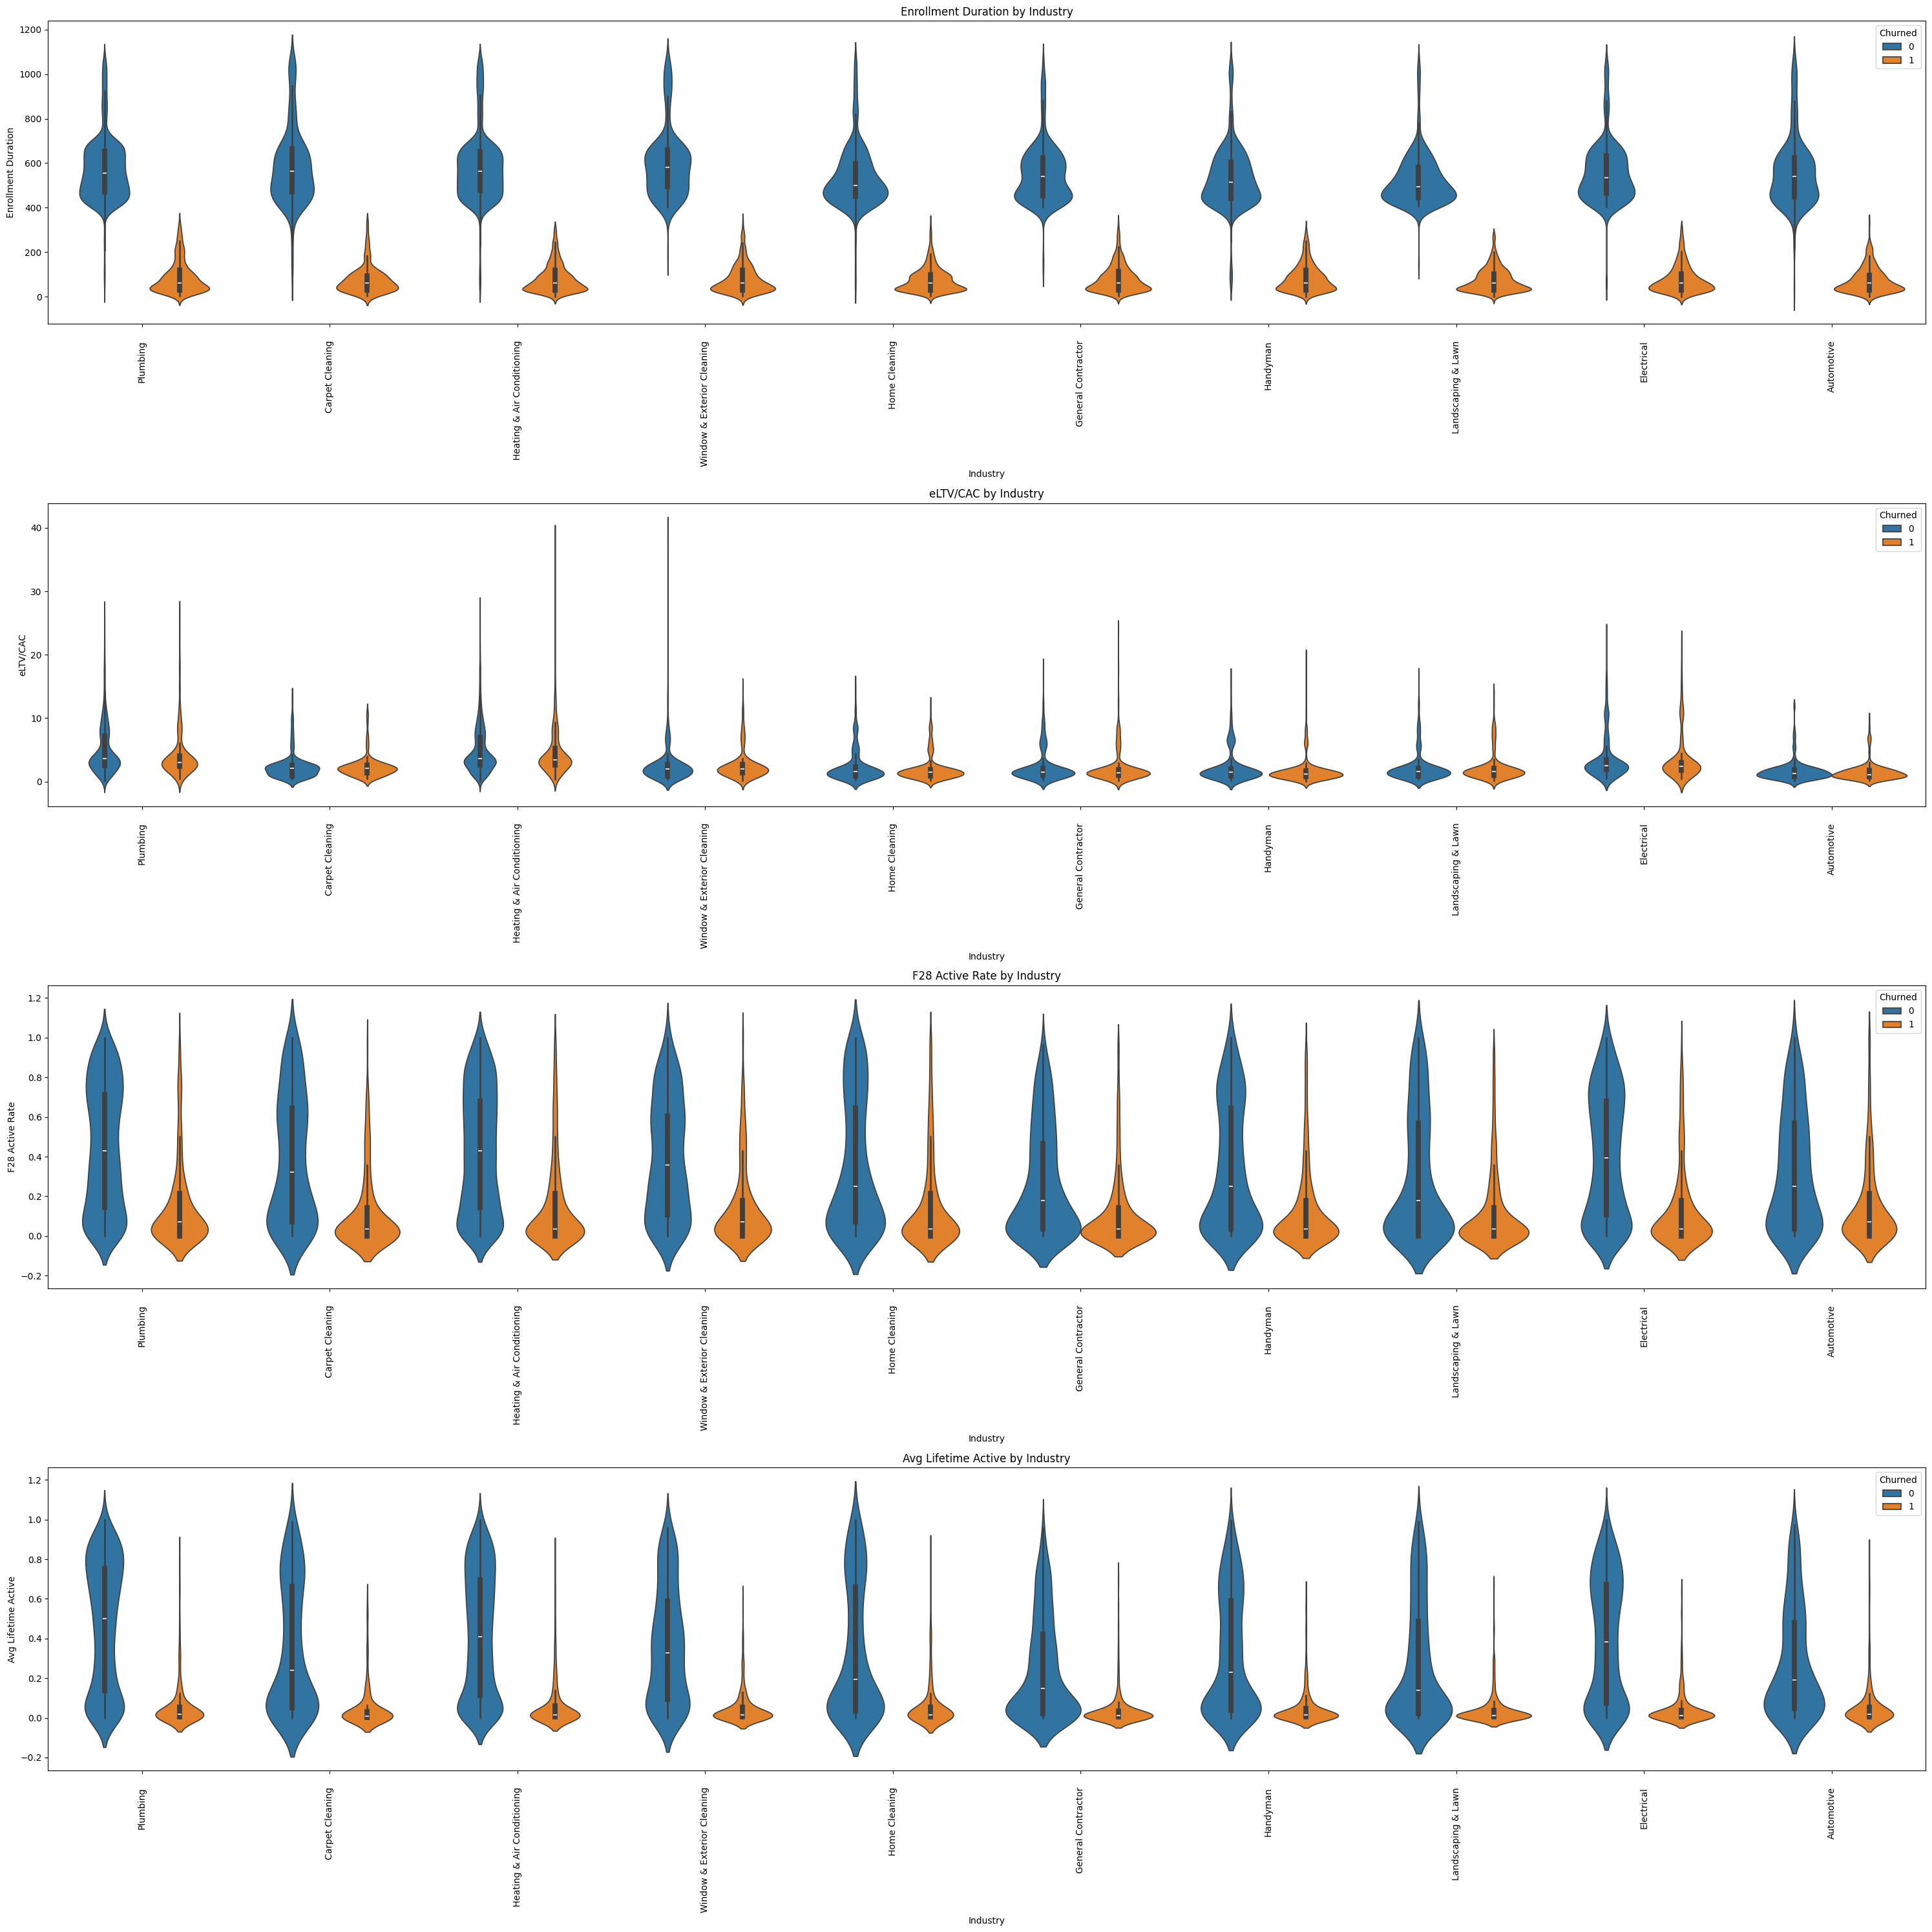

In [27]:
#violin plot for the promotion type
fig, axs = plt.subplots(4,1, figsize=(30, 30))

sns.violinplot(x='Industry', y='Enrollment Duration', data=df_10, ax=axs[0], hue='Churned')
axs[0].set_title('Enrollment Duration by Industry')  # Set title for the first subplot

sns.violinplot(x='Industry', y='eLTV/CAC', data=df_10, ax=axs[1], hue='Churned')
axs[1].set_title('eLTV/CAC by Industry')  # Set title for the second subplot

sns.violinplot(x='Industry', y='F28 Active Rate', data=df_10, ax=axs[2], hue='Churned')
axs[2].set_title('F28 Active Rate by Industry')  # Set title for the third subplot

sns.violinplot(x='Industry', y='Avg Lifetime Active', data=df_10, ax=axs[3], hue='Churned')
axs[3].set_title('Avg Lifetime Active by Industry')  # Set title for the fourth subplot

#tilt the x-axis labels and space them out
for ax in axs:
    plt.sca(ax)
    plt.xticks(rotation=90)
    ax.tick_params(axis='x', which='major', pad=15)




plt.tight_layout()
plt.show()

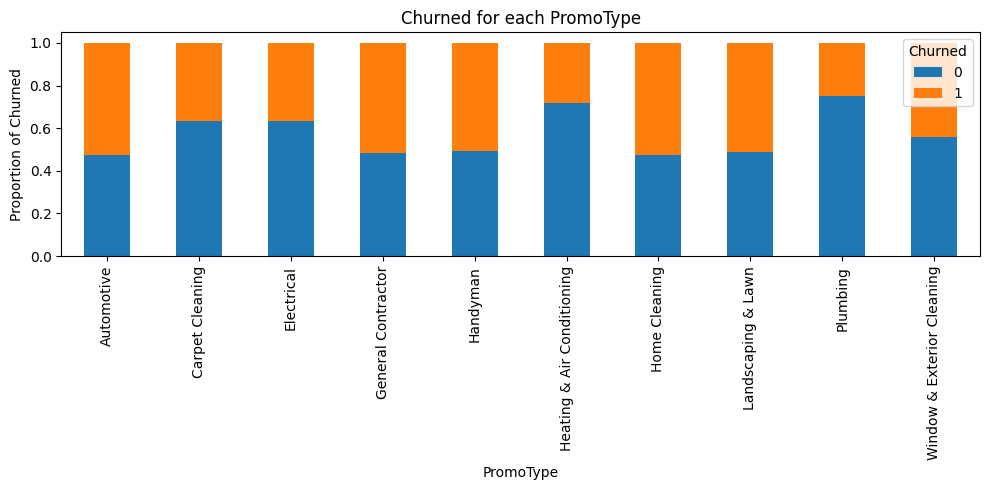

In [28]:
# Create the figure and axis
fig, ax = plt.subplots(figsize=(10, 5))

# Group by PromoType and Churned, count occurrences, and unstack for plotting
grouped = df_10[df_10['Churned'].notnull()].groupby(['Industry', 'Churned']).size().unstack()

# Normalize the data to show proportions (optional)
grouped = grouped.div(grouped.sum(axis=1), axis=0)

# Plot the stacked bar chart
grouped.plot(kind='bar', stacked=True, ax=ax)

# Set title and labels
ax.set_title('Churned for each PromoType')
ax.set_ylabel('Proportion of Churned')  # Change to 'Count' if not normalizing
ax.set_xlabel('PromoType')

# Display the plot
plt.tight_layout()
plt.show()

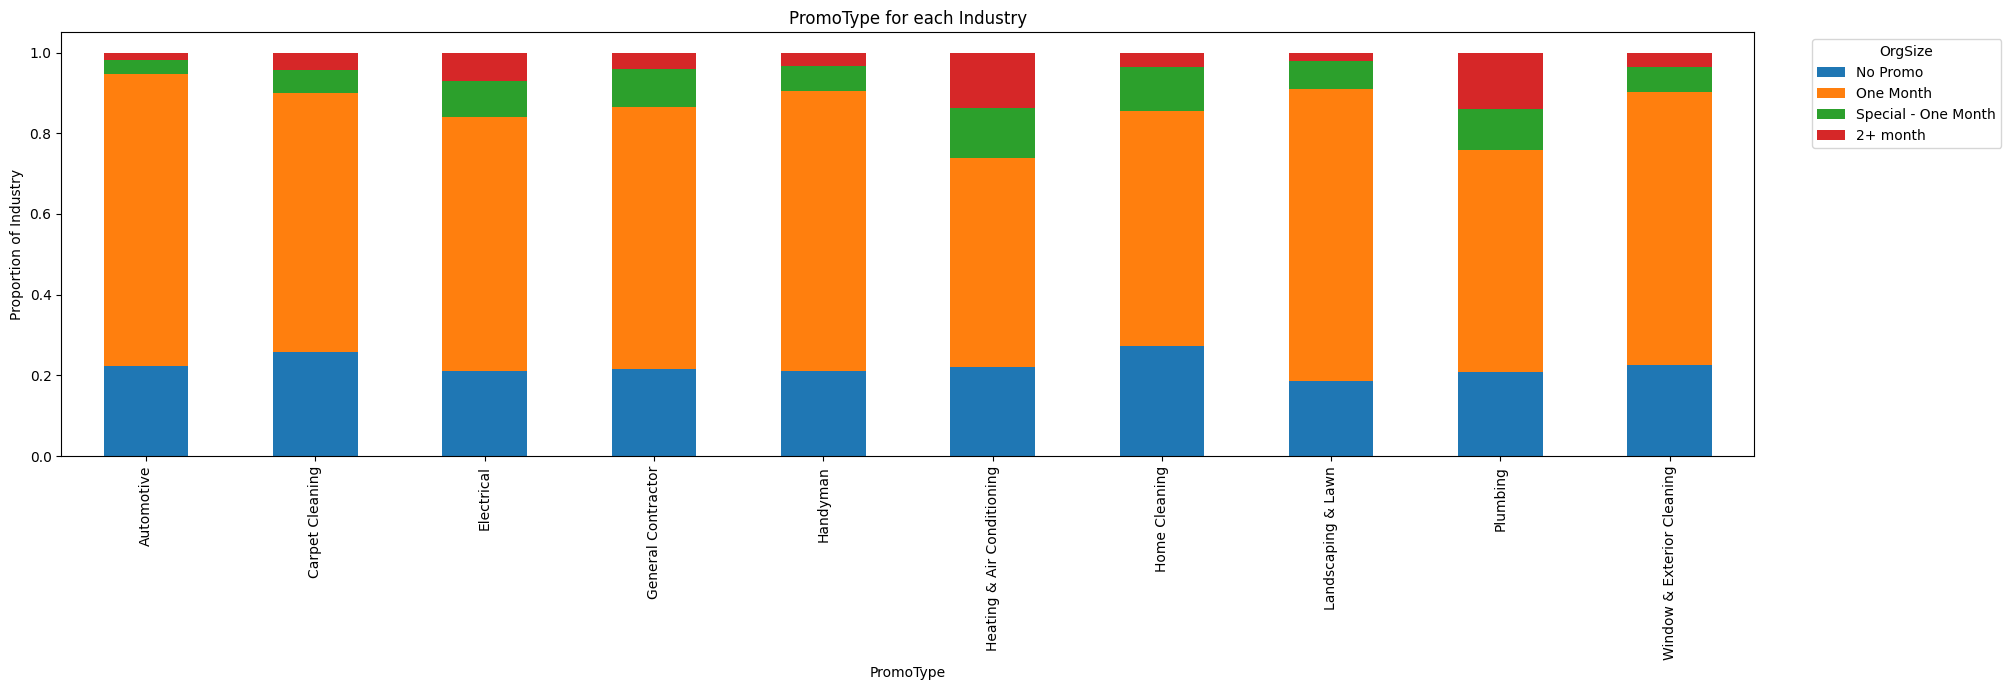

In [29]:
# Create the figure and axis ---------------------------
fig, ax = plt.subplots(figsize=(20, 7))

# Group by OrgSize and OrgSize, count occurrences, and unstack for plotting 
grouped = df_10[df_10['PromoType'].notnull()].groupby(['Industry', 'PromoType']).size().unstack()

# Normalize the data to show proportions (optional)
grouped = grouped.div(grouped.sum(axis=1), axis=0)

# Plot the stacked bar chart
grouped.plot(kind='bar', stacked=True, ax=ax)

# Set title and labels
ax.set_title('PromoType for each Industry')
ax.set_ylabel('Proportion of Industry')  # Change to 'Count' if not normalizing
ax.set_xlabel('PromoType')

# Move the legend to a better location
ax.legend(title='OrgSize', loc='upper right', bbox_to_anchor=(1.15, 1))

# Display the plot
plt.tight_layout()
plt.show()

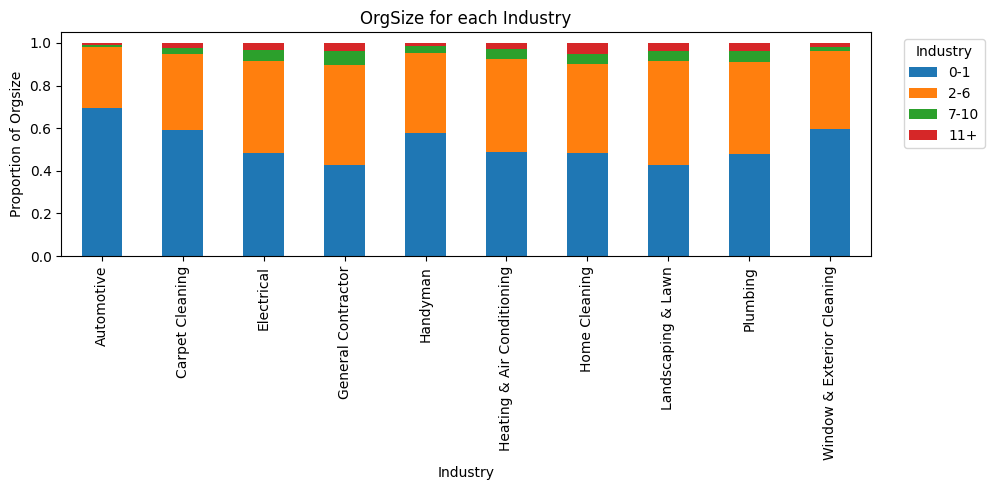

In [30]:
# Create the figure and axis
fig, ax = plt.subplots(figsize=(10, 5))

# Group by OrgSize and OrgSize, count occurrences, and unstack for plotting
grouped = df_10[df_10['OrgSize'].notnull()].groupby(['Industry', 'OrgSize']).size().unstack()

# Normalize the data to show proportions (optional)
grouped = grouped.div(grouped.sum(axis=1), axis=0)

# Plot the stacked bar chart
grouped.plot(kind='bar', stacked=True, ax=ax)

# Set title and labels
ax.set_title('OrgSize for each Industry')
ax.set_ylabel('Proportion of Orgsize')  # Change to 'Count' if not normalizing
ax.set_xlabel('Industry')

# Move the legend to a better location
ax.legend(title='Industry', loc='upper right', bbox_to_anchor=(1.15, 1))

# Display the plot
plt.tight_layout()
plt.show()

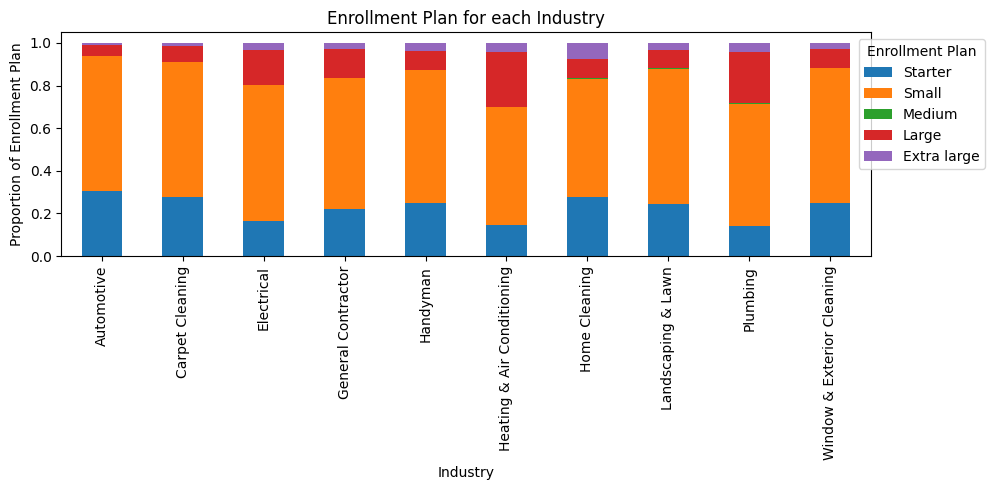

In [31]:
# Create the figure and axis
fig, ax = plt.subplots(figsize=(10, 5))

# Group by OrgSize and OrgSize, count occurrences, and unstack for plotting
grouped = df_10[df_10['Enrollment Plan'].notnull()].groupby(['Industry', 'Enrollment Plan']).size().unstack()

# Normalize the data to show proportions (optional)
grouped = grouped.div(grouped.sum(axis=1), axis=0)

# Plot the stacked bar chart
grouped.plot(kind='bar', stacked=True, ax=ax)

# Set title and labels
ax.set_title('Enrollment Plan for each Industry')
ax.set_ylabel('Proportion of Enrollment Plan')  # Change to 'Count' if not normalizing
ax.set_xlabel('Industry')

# Move the legend to a better location
ax.legend(title='Enrollment Plan', loc='upper right', bbox_to_anchor=(1.15, 1))

# Display the plot
plt.tight_layout()
plt.show()

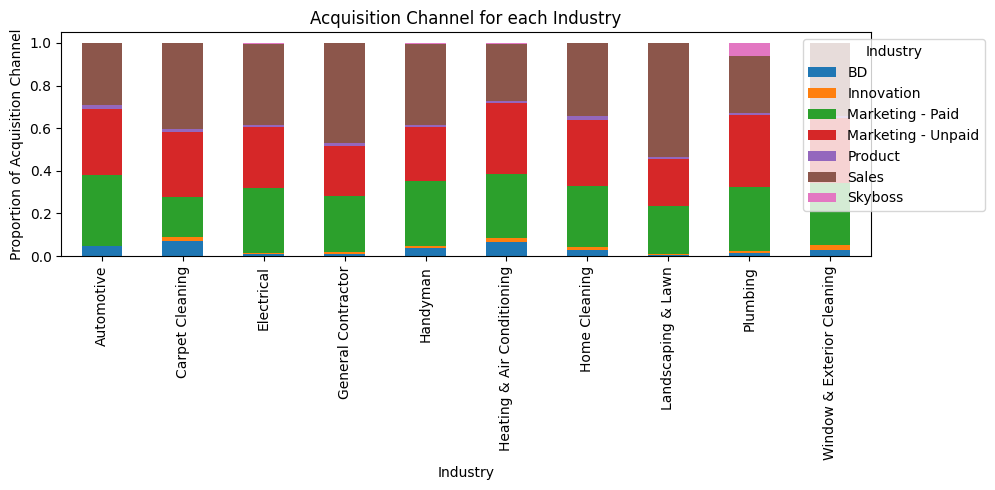

In [32]:
# Create the figure and axis
fig, ax = plt.subplots(figsize=(10, 5))

# Group by OrgSize and OrgSize, count occurrences, and unstack for plotting
grouped = df_10[df_10['Acquisition Channel'].notnull()].groupby(['Industry', 'Acquisition Channel']).size().unstack()

# Normalize the data to show proportions (optional)
grouped = grouped.div(grouped.sum(axis=1), axis=0)

# Plot the stacked bar chart
grouped.plot(kind='bar', stacked=True, ax=ax)

# Set title and labels
ax.set_title('Acquisition Channel for each Industry')
ax.set_ylabel('Proportion of Acquisition Channel')  # Change to 'Count' if not normalizing
ax.set_xlabel('Industry')

# Move the legend to a better location
ax.legend(title='Industry', loc='upper right', bbox_to_anchor=(1.15, 1))

# Display the plot
plt.tight_layout()
plt.show()

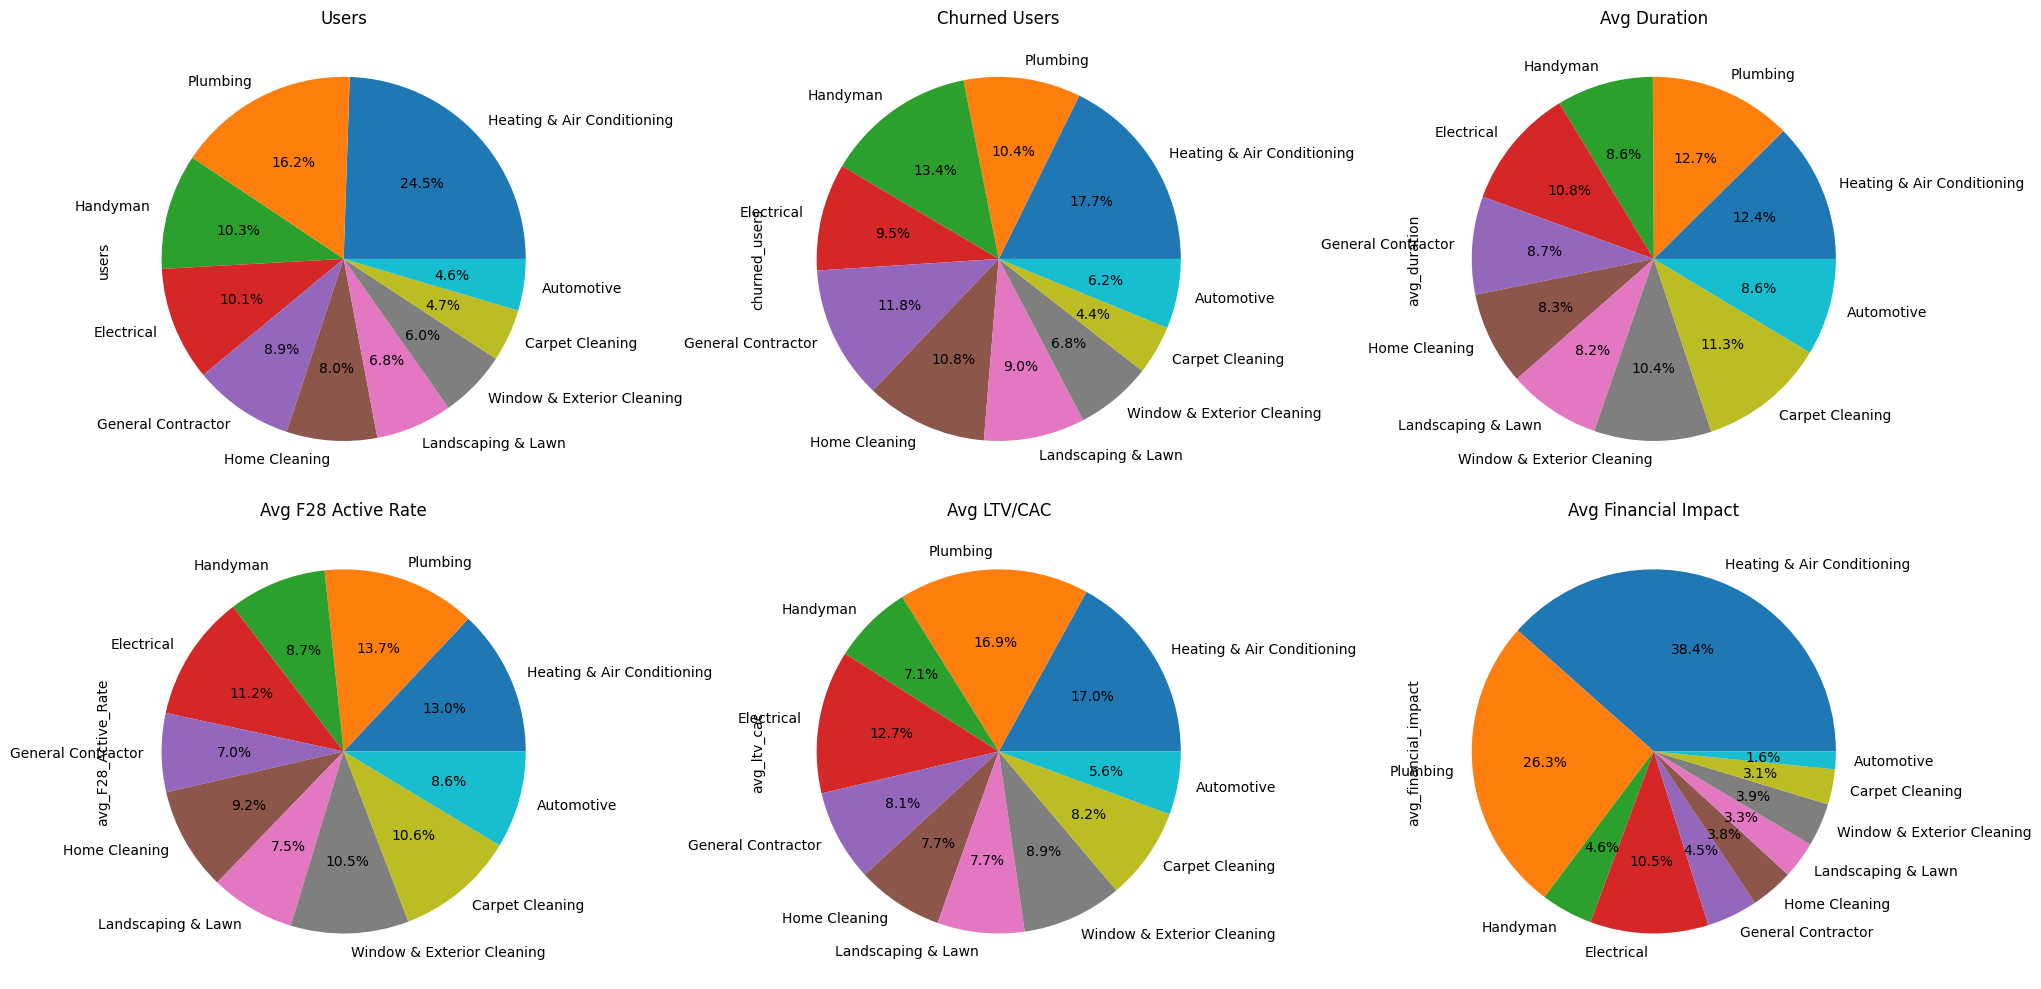

In [33]:
#subplot of the df_promo dataframe with 6 pie charts for: users, churned_users,avg_duration, 
# avg_F28_Active_Rate, avg_ltv_cac, avg_financial_impact
fig, axs = plt.subplots(2,3, figsize=(20, 10))
df_promo_10['users'].plot.pie(ax=axs[0,0], autopct='%1.1f%%')
axs[0,0].set_title('Users')

df_promo_10['churned_users'].plot.pie(ax=axs[0,1], autopct='%1.1f%%')
axs[0,1].set_title('Churned Users')

df_promo_10['avg_duration'].plot.pie(ax=axs[0,2], autopct='%1.1f%%')
axs[0,2].set_title('Avg Duration')

df_promo_10['avg_F28_Active_Rate'].plot.pie(ax=axs[1,0], autopct='%1.1f%%')
axs[1,0].set_title('Avg F28 Active Rate')

df_promo_10['avg_ltv_cac'].plot.pie(ax=axs[1,1], autopct='%1.1f%%')
axs[1,1].set_title('Avg LTV/CAC')

df_promo_10['avg_financial_impact'].plot.pie(ax=axs[1,2], autopct='%1.1f%%')
axs[1,2].set_title('Avg Financial Impact')


plt.tight_layout()
plt.show()


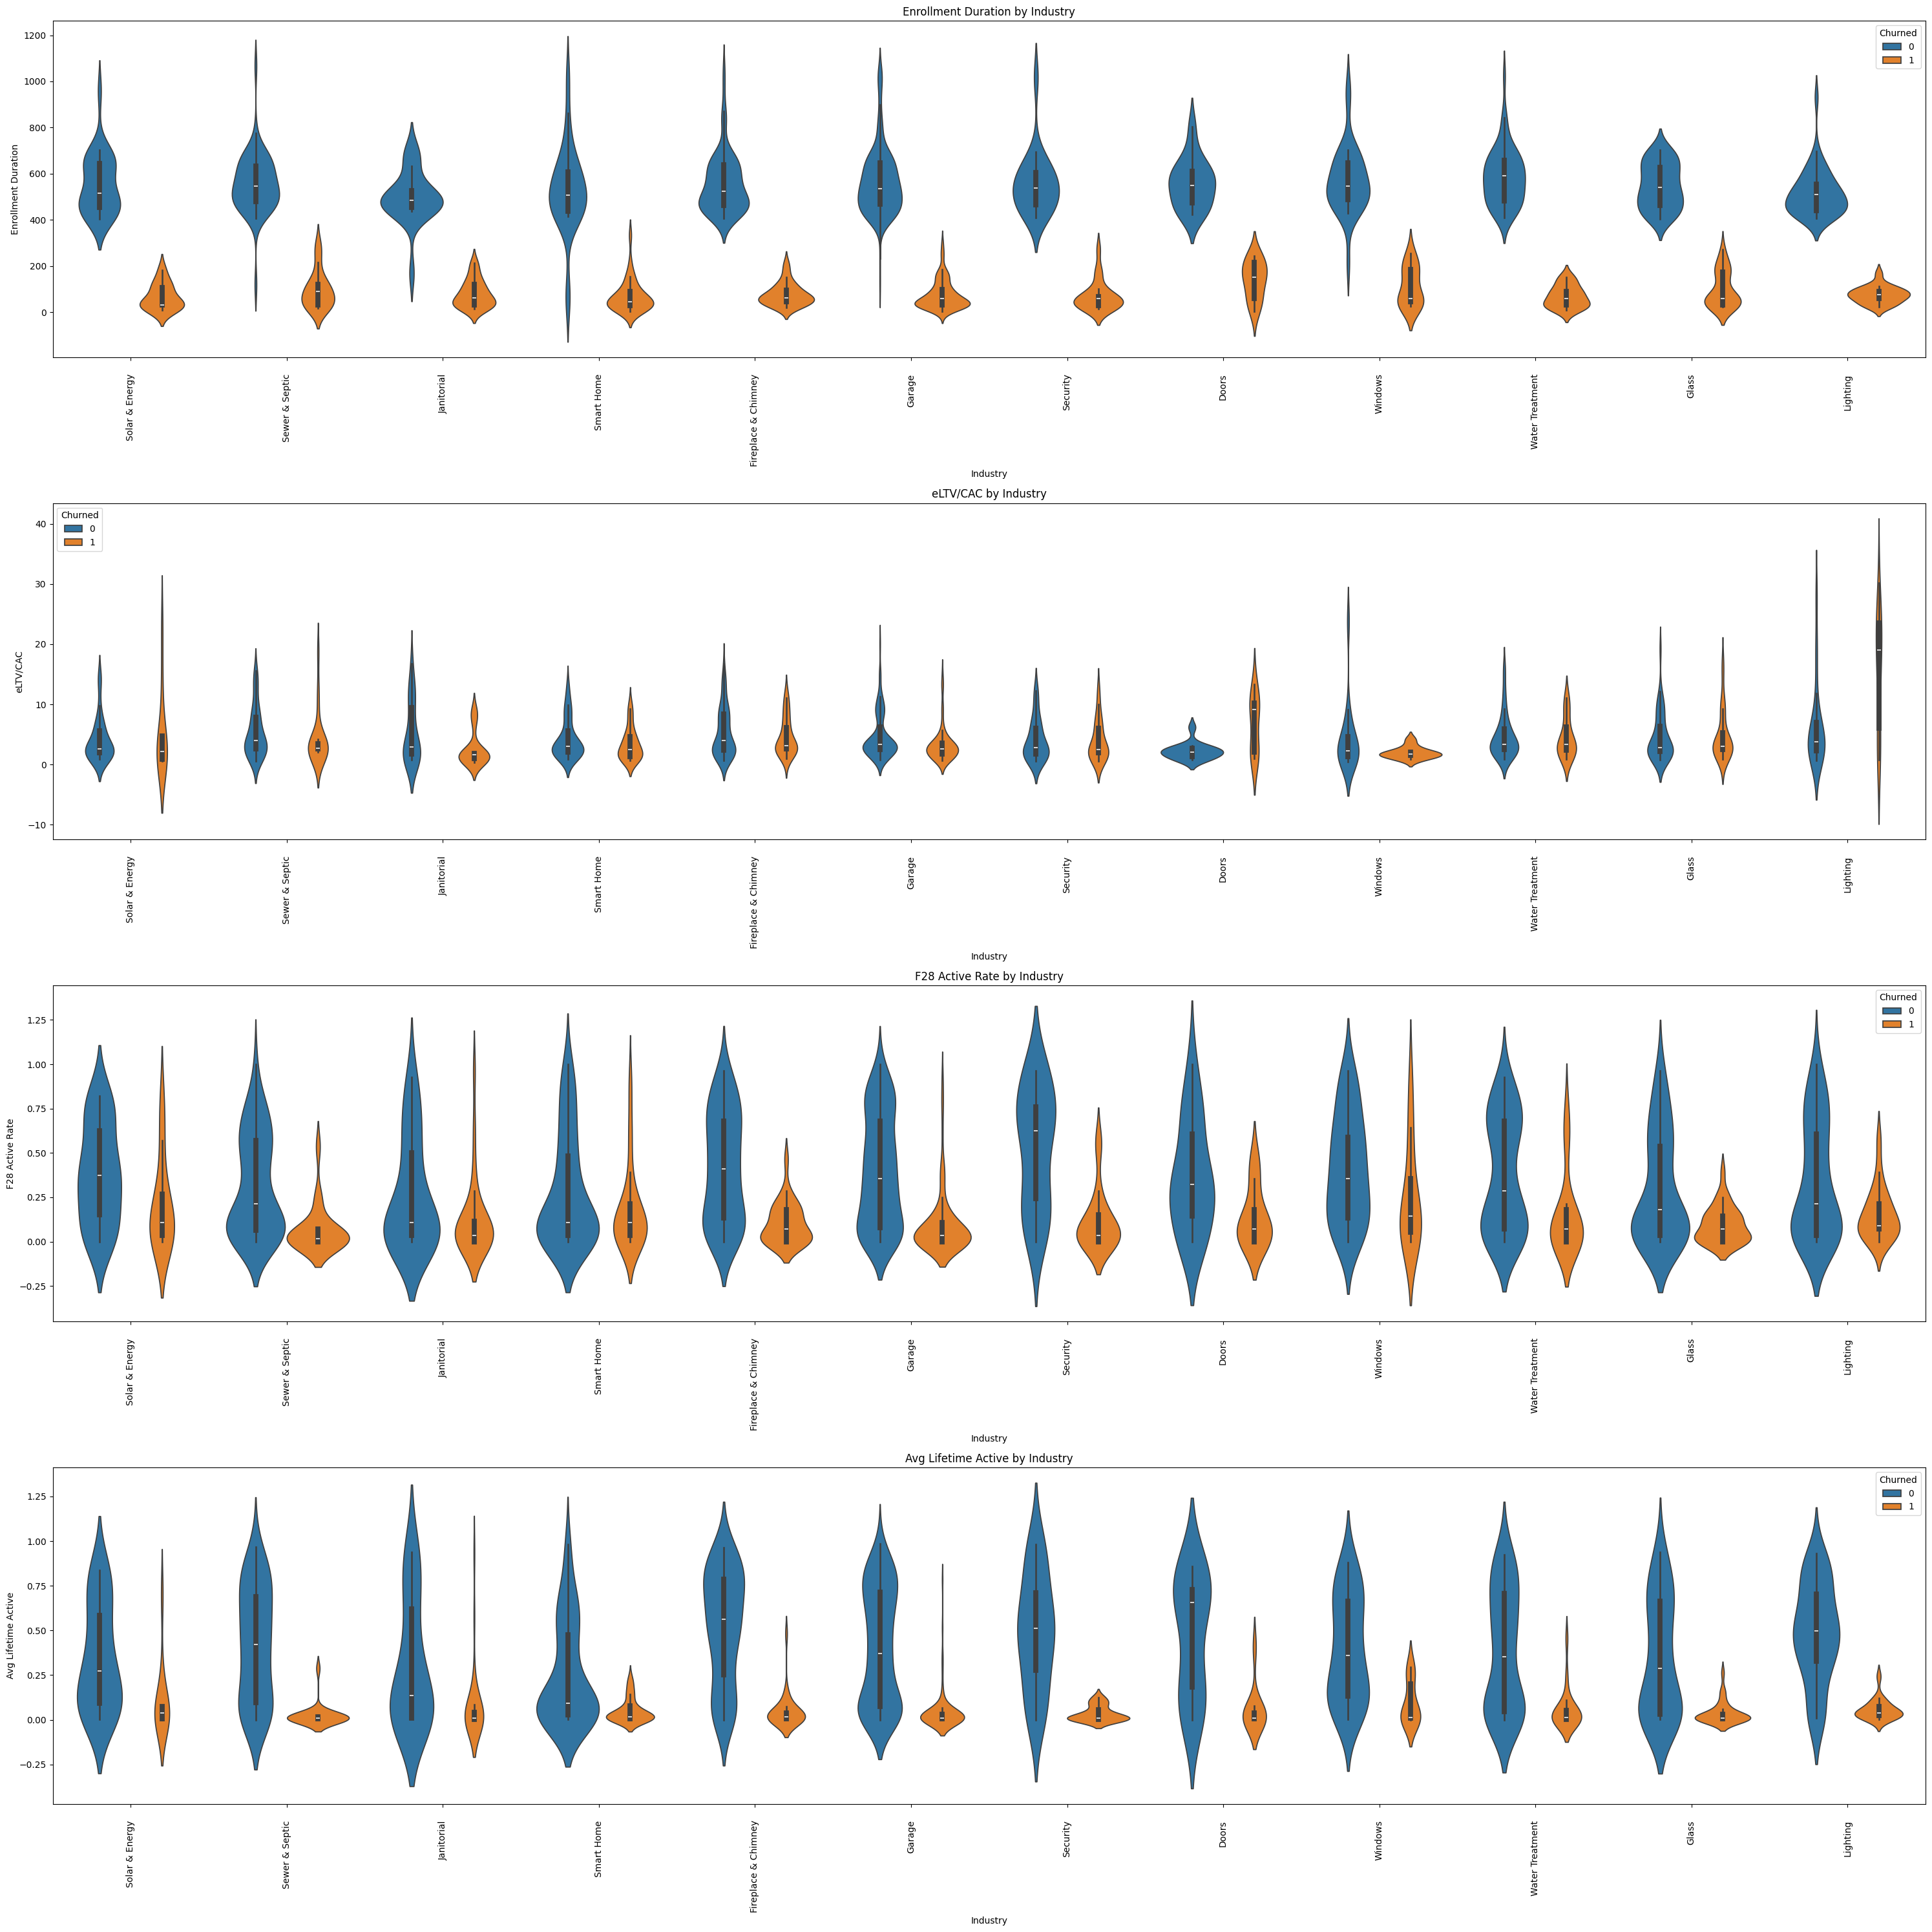

In [34]:
#violin plot for the promotion type
fig, axs = plt.subplots(4,1, figsize=(30, 30))

sns.violinplot(x='Industry', y='Enrollment Duration', data=df_pot, ax=axs[0], hue='Churned')
axs[0].set_title('Enrollment Duration by Industry')  # Set title for the first subplot

sns.violinplot(x='Industry', y='eLTV/CAC', data=df_pot, ax=axs[1], hue='Churned')
axs[1].set_title('eLTV/CAC by Industry')  # Set title for the second subplot

sns.violinplot(x='Industry', y='F28 Active Rate', data=df_pot, ax=axs[2], hue='Churned')
axs[2].set_title('F28 Active Rate by Industry')  # Set title for the third subplot

sns.violinplot(x='Industry', y='Avg Lifetime Active', data=df_pot, ax=axs[3], hue='Churned')
axs[3].set_title('Avg Lifetime Active by Industry')  # Set title for the fourth subplot

#tilt the x-axis labels and space them out
for ax in axs:
    plt.sca(ax)
    plt.xticks(rotation=90)
    ax.tick_params(axis='x', which='major', pad=15)




plt.tight_layout()
plt.show()

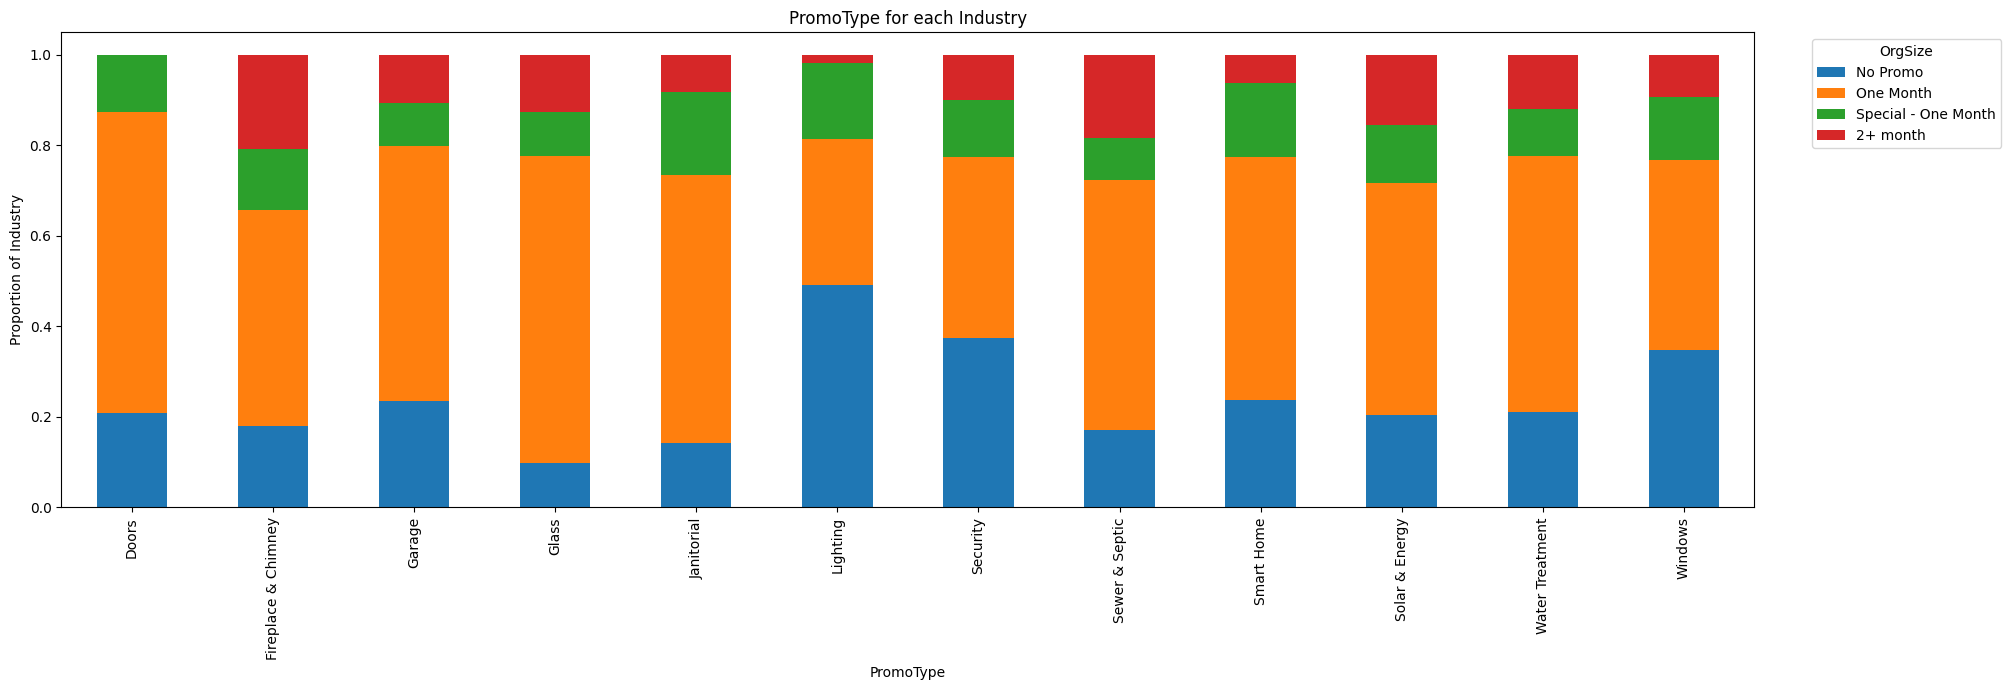

In [35]:
# Create the figure and axis ---------------------------
fig, ax = plt.subplots(figsize=(20, 7))

# Group by OrgSize and OrgSize, count occurrences, and unstack for plotting 
grouped = df_pot[df_pot['PromoType'].notnull()].groupby(['Industry', 'PromoType']).size().unstack()

# Normalize the data to show proportions (optional)
grouped = grouped.div(grouped.sum(axis=1), axis=0)

# Plot the stacked bar chart
grouped.plot(kind='bar', stacked=True, ax=ax)

# Set title and labels
ax.set_title('PromoType for each Industry')
ax.set_ylabel('Proportion of Industry')  # Change to 'Count' if not normalizing
ax.set_xlabel('PromoType')

# Move the legend to a better location
ax.legend(title='OrgSize', loc='upper right', bbox_to_anchor=(1.15, 1))

# Display the plot
plt.tight_layout()
plt.show()

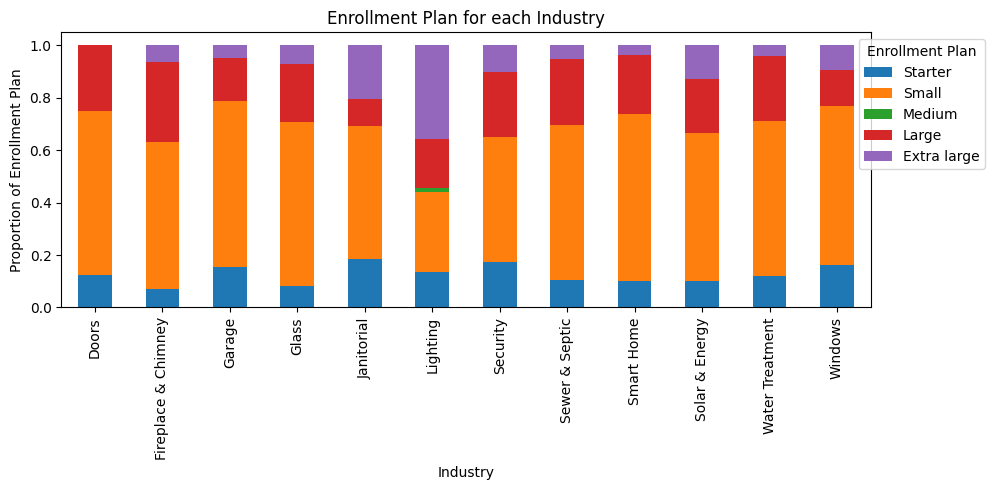

In [36]:
# Create the figure and axis
fig, ax = plt.subplots(figsize=(10, 5))

# Group by OrgSize and OrgSize, count occurrences, and unstack for plotting
grouped = df_pot[df_pot['Enrollment Plan'].notnull()].groupby(['Industry', 'Enrollment Plan']).size().unstack()

# Normalize the data to show proportions (optional)
grouped = grouped.div(grouped.sum(axis=1), axis=0)

# Plot the stacked bar chart
grouped.plot(kind='bar', stacked=True, ax=ax)

# Set title and labels
ax.set_title('Enrollment Plan for each Industry')
ax.set_ylabel('Proportion of Enrollment Plan')  # Change to 'Count' if not normalizing
ax.set_xlabel('Industry')

# Move the legend to a better location
ax.legend(title='Enrollment Plan', loc='upper right', bbox_to_anchor=(1.15, 1))

# Display the plot
plt.tight_layout()
plt.show()

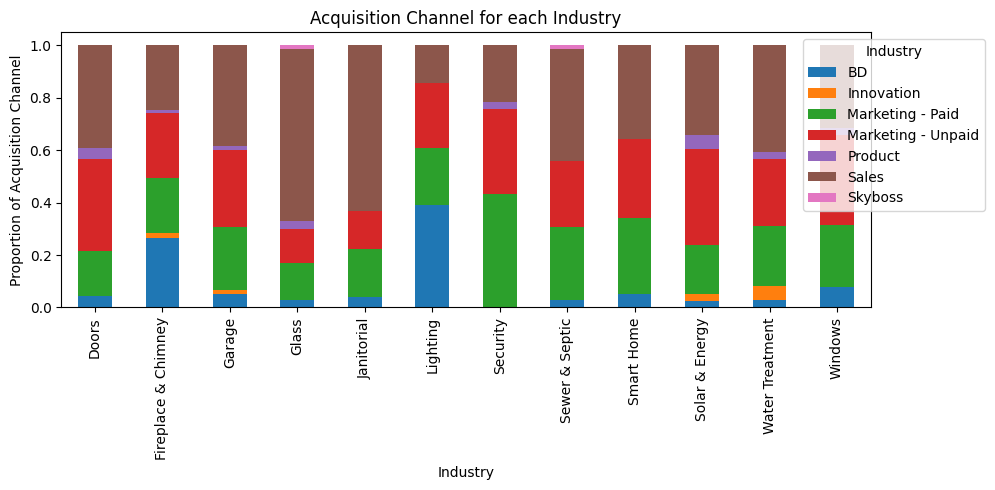

In [37]:
# Create the figure and axis
fig, ax = plt.subplots(figsize=(10, 5))

# Group by OrgSize and OrgSize, count occurrences, and unstack for plotting
grouped = df_pot[df_pot['Acquisition Channel'].notnull()].groupby(['Industry', 'Acquisition Channel']).size().unstack()

# Normalize the data to show proportions (optional)
grouped = grouped.div(grouped.sum(axis=1), axis=0)

# Plot the stacked bar chart
grouped.plot(kind='bar', stacked=True, ax=ax)

# Set title and labels
ax.set_title('Acquisition Channel for each Industry')
ax.set_ylabel('Proportion of Acquisition Channel')  # Change to 'Count' if not normalizing
ax.set_xlabel('Industry')

# Move the legend to a better location
ax.legend(title='Industry', loc='upper right', bbox_to_anchor=(1.15, 1))

# Display the plot
plt.tight_layout()
plt.show()

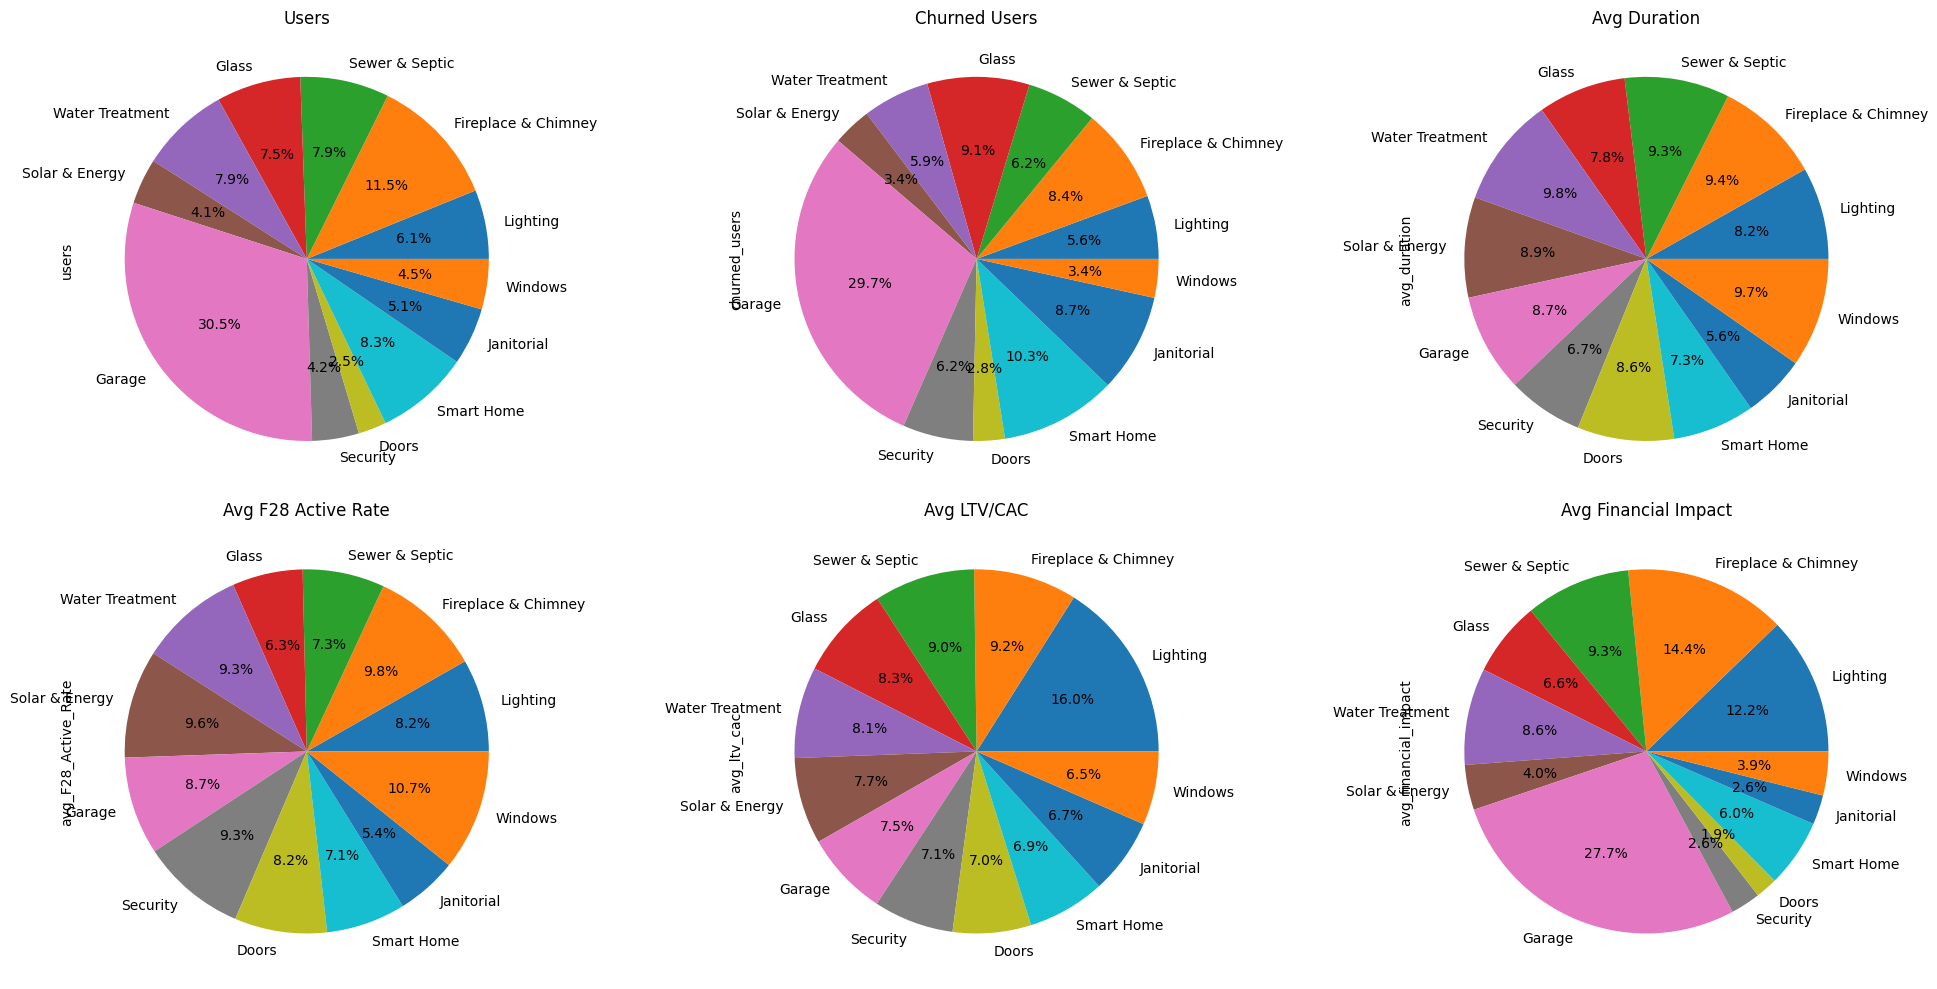

In [38]:
#subplot of the df_promo dataframe with 6 pie charts for: users, churned_users,avg_duration, 
# avg_F28_Active_Rate, avg_ltv_cac, avg_financial_impact
fig, axs = plt.subplots(2,3, figsize=(20, 10))
df_potential_10['users'].plot.pie(ax=axs[0,0], autopct='%1.1f%%')
axs[0,0].set_title('Users')

df_potential_10['churned_users'].plot.pie(ax=axs[0,1], autopct='%1.1f%%')
axs[0,1].set_title('Churned Users')

df_potential_10['avg_duration'].plot.pie(ax=axs[0,2], autopct='%1.1f%%')
axs[0,2].set_title('Avg Duration')

df_potential_10['avg_F28_Active_Rate'].plot.pie(ax=axs[1,0], autopct='%1.1f%%')
axs[1,0].set_title('Avg F28 Active Rate')

df_potential_10['avg_ltv_cac'].plot.pie(ax=axs[1,1], autopct='%1.1f%%')
axs[1,1].set_title('Avg LTV/CAC')

df_potential_10['avg_financial_impact'].plot.pie(ax=axs[1,2], autopct='%1.1f%%')
axs[1,2].set_title('Avg Financial Impact')


plt.tight_layout()
plt.show()


In [39]:
#filter top 5 industries sorted by users
df_promo_5 = df_promo.head(5)

#filter df by the industry in df_promo_5
df_5 = df[df['Industry'].isin(df_promo_5.index)]
df_promo_5

,Industry_Group,users,users_perc,churned_users,churned_users_perc,share_of_churned_users,avg_duration,avg_F28_Active_Rate,avg_Avg_Lifetime_Active,avg_ltv_cac,avg_financial_impact,most_predominant_PromoType,most_predominant_Enrollment_Plan
Industry,,,,,,,,,,,,,
Heating & Air Conditioning,Heating & Air Conditioning,2974,0.178297,836.0,0.281103,0.124720,443.470746,0.352195,0.320489,4.868519,10408.893934,One Month,Small
Plumbing,Plumbing,1964,0.117746,491.0,0.250000,0.073251,453.943992,0.371140,0.365072,4.835897,7123.276923,One Month,Small
Handyman,Handyman,1246,0.074700,632.0,0.507223,0.094286,307.174960,0.236024,0.183602,2.029839,1246.320968,One Month,Small
Electrical,Electrical,1230,0.073741,450.0,0.365854,0.067134,385.405691,0.304142,0.268502,3.645977,2843.862069,One Month,Small
General Contractor,General Contractor,1085,0.065048,559.0,0.515207,0.083395,311.112442,0.189816,0.140638,2.326873,1223.935019,One Month,Small


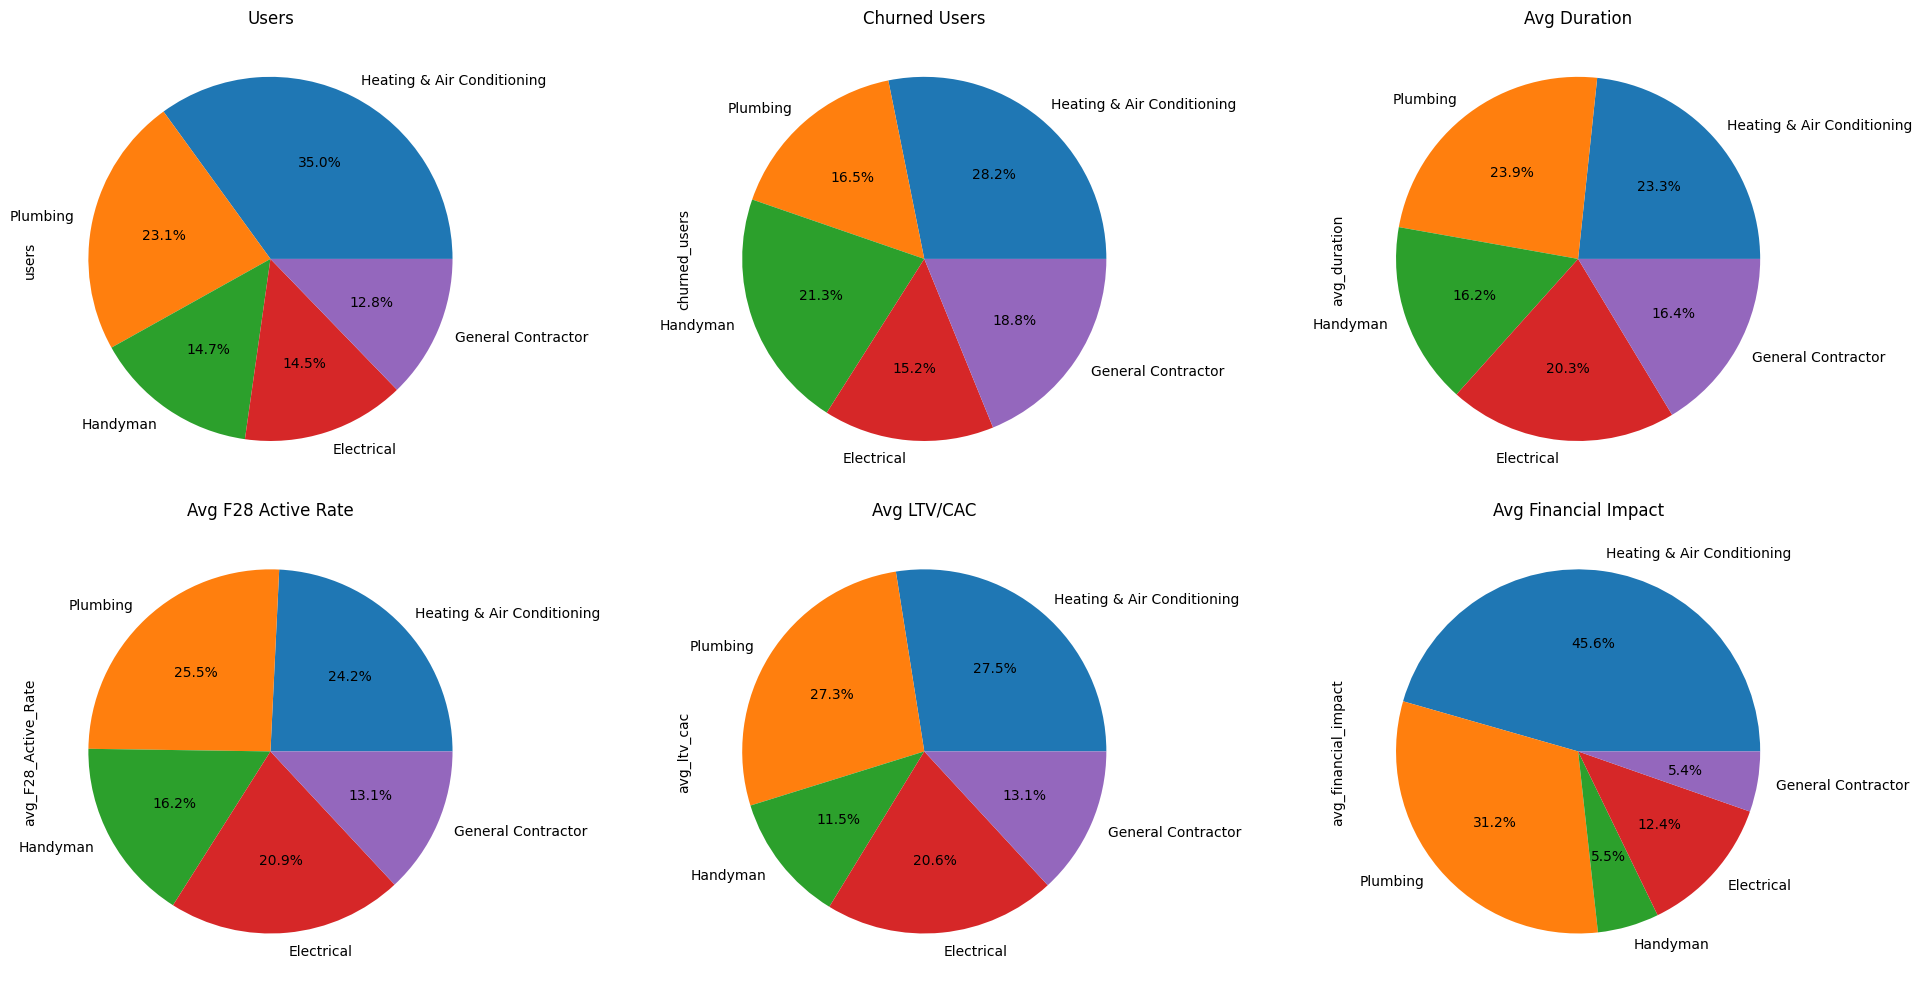

In [41]:
#subplot of the df_promo dataframe with 6 pie charts for: users, churned_users,avg_duration, 
# avg_F28_Active_Rate, avg_ltv_cac, avg_financial_impact
fig, axs = plt.subplots(2,3, figsize=(20, 10))
df_promo_5['users'].plot.pie(ax=axs[0,0], autopct='%1.1f%%')
axs[0,0].set_title('Users')

df_promo_5['churned_users'].plot.pie(ax=axs[0,1], autopct='%1.1f%%')
axs[0,1].set_title('Churned Users')

df_promo_5['avg_duration'].plot.pie(ax=axs[0,2], autopct='%1.1f%%')
axs[0,2].set_title('Avg Duration')

df_promo_5['avg_F28_Active_Rate'].plot.pie(ax=axs[1,0], autopct='%1.1f%%')
axs[1,0].set_title('Avg F28 Active Rate')

df_promo_5['avg_ltv_cac'].plot.pie(ax=axs[1,1], autopct='%1.1f%%')
axs[1,1].set_title('Avg LTV/CAC')

df_promo_5['avg_financial_impact'].plot.pie(ax=axs[1,2], autopct='%1.1f%%')
axs[1,2].set_title('Avg Financial Impact')


plt.tight_layout()
plt.show()